<a href="https://colab.research.google.com/github/pastrop/kaggle/blob/master/text_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key Words & Documents Clusters

Open-source based set of capabilities allowing to analyze text datasets.  Currently Implemented Functionality:
1. Key words indentification for a text corpus (YAKE algorithm)
2. Key words identification for each document in the corpus (YAKE algorithms)
3. Basic sentiment analysis (currently using Sienbert or J-Hartman models from the Huggingface Hub)
4. Advanced Sentiment analysis & text classification (Using SetFit model with few shot training)
5. Semantic Search & Clustering (Approximate Nearest Neighbours, ANNOY package)
6. Basic vizualization (UMAP or PCA for the dimensionality reduction, Altair or Matplotlib for plotting)

**Work in Progress!**

In [ ]:
import pandas as pd

In [ ]:
%%capture
!pip install ipywidgets

In [ ]:
import ipywidgets as widgets
from IPython.display import display
layout = widgets.Layout(width='auto', height='40px')

In [ ]:
# file upload while using Google Colab
from google.colab import files
uploaded = files.upload()

Saving alpha_test.csv to alpha_test.csv


In [ ]:
# Dataframe processing (CSV format is expected, minimal text pre-processing at the moment (write you own if you needed it :) ), change the file name as needed)
df = pd.read_csv('alpha_test.csv')

In [ ]:
df_clean = df[df['text'].apply(lambda x: isinstance(x, str))]

In [ ]:
#above code wrapped in a function
def text_input(file = 'alpha_test.csv'):
  df = pd.read_csv(file)
  df_clean = df[df['text'].apply(lambda x: isinstance(x, str))]
  texts = [item.replace("\t", " ") for item in df_clean['text']]
  return texts

In [ ]:
texts_raw = text_input()

In [ ]:
#Widget to pick the number of documents to process
style = {'description_width': 'initial'}
box = widgets.BoundedIntText(
    min=1,
    max=4998,
    step=10,
    description='# of docs to process:',
    value=len(texts_raw),
    style = style
)
display(box)

BoundedIntText(value=4998, description='# of docs to process:', max=4998, min=1, step=10, style=DescriptionSty…

In [ ]:
#texts_raw contains all the document being ingested.  You may want to limit the number of docs to analyze
texts = texts_raw[:box.value]

In [ ]:
#Create a single blob of text
corpus = ' '.join(texts)

# Keywords

In [ ]:
%%capture
!pip install yake

In [ ]:
import yake

In [ ]:
# YAKE Config
kw_extractor = yake.KeywordExtractor()
language = 'en'
max_ngram_size = 2
deduplication_threshold = 0.9
numOfKeywords = 50

In [ ]:
#Keyword for the corpus a.k.a Global Concepts
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(corpus)
keywords

In [ ]:
#select a number of keywords to work with
def keywords_number(n = len(keywords), input=keywords):
  return [item[0] for item in input[:n]]

In [ ]:
top_10 = keywords_number(10)
all_keywords = keywords_number()

In [ ]:
#Keyword for the individual documents
custom_kw_extractor_docs = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=10, features=None)

In [ ]:
#Summarizing each document to a set of keywords
distilled_docs = []
for item in texts:
  keywrds = custom_kw_extractor_docs.extract_keywords(item)
  tmp = [item[0] for item in keywrds]
  distilled_docs.append(tmp)

Counting number of documents that include global concepts being found

In [ ]:
count_dict = {}
concepts_doc = {}
for item in all_keywords:
    count_dict[item]=0
    concepts_doc[item] =[]
    for index, doc in enumerate(texts):
        if doc.find(item) != -1:
            count_dict[item] +=1
            concepts_doc[item].append(index)
counts= list(count_dict.values()) 

# Embeddings for original Documents & Summarized Documents distilled Using S-Bert

In [ ]:
%%capture
!pip install -U sentence-transformers

In [ ]:
%%capture
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2', device = None)
model.max_seq_length = 300

In [ ]:
# Embeddings for Distilled Docs
emb_distilled_input = [' '.join(item) for item in distilled_docs]
emb_distilled = model.encode(emb_distilled_input)

In [ ]:
# Embeddings for Original Docs
emb_texts = model.encode(texts)

Find keywords most closely associated with a given global concept

In [ ]:
#Selecting a concept from the top 10 concept for the classifier training (work in progress, not completely implemented, code below is POC)
select_target = widgets.Dropdown(options=all_keywords,
                            description='Pick a concept:',
                            disabled=False,
                            value = all_keywords[1],
                            style = style
                            )
display(select_target)

Dropdown(description='Pick a concept:', index=1, options=('BLACK', 'flavors Syrupy', 'Tastes malty', 'beer', '…

In [ ]:
trg = select_target.value
target = model.encode(trg)
#Find closest documents
cosine_score = util.cos_sim(target, emb_distilled)

In [ ]:
final_scores = list(enumerate(cosine_score.flatten().tolist()))

In [ ]:
res = sorted(final_scores, key = lambda x:x[1], reverse=True)
res[:5]

In [ ]:
out_distilled = []
out_original = []
for item in res[:5]:
  print(distilled_docs[item[0]])
  out_distilled.append(distilled_docs[item[0]])
  out_original.append(texts[item[0]]) 

['BLACK', 'flavors Syrupy', 'Tastes malty', 'beer', 'alcohol Tastes', 'Syrupy', 'light', 'Tastes', 'alcohol', 'malty good']
['malt Taste', 'boring Mouthfeel', 'thin Drinkability', 'moderate carbonation', 'bitter finish', 'thin head', 'grain hop', 'slight bitter', 'easy drinking', 'alot macros']
['malt', 'pretty good', 'good', 'bit', 'BORIS', 'pretty', 'dark body', 'black malt', 'chocolate', 'flavor']
['Poured', 'brown', 'bottle', 'malt', 'malts', 'Smell', 'mild', 'hints', 'Taste', 'crisp']
['Roasted malts', 'Tastes sweet', 'Completely black', 'great beer', 'malts', 'Roasted', 'sweet', 'Completely', 'taste', 'beer']


In [ ]:
#(1)keywords co-occuring with with the target concept, 
#(2)kewords from the documents that are close in meaning yet doesn't include the target concept
closest = set()
associated = set()
for item in res[:10]:
  if ' '.join(distilled_docs[item[0]]).find(trg) != -1:
    closest.update(distilled_docs[item[0]]) 
  else:
    associated.update(distilled_docs[item[0]]) 
closest.remove(trg)  

# Clusterning using ANNOY Package (Approximate K-nearest neighbours)

In [ ]:
!pip install annoy

In [ ]:
from annoy import AnnoyIndex

In [ ]:
#Template Code
# Create the search index, pass the size of embedding
search_index = AnnoyIndex(768, 'angular')
# Add all the vectors to the search index
for i in range(len(embeds)):
    search_index.add_item(i, embeds[i])

search_index.build(10) # 10 trees
#search_index.save('askhn.ann')

In [ ]:
#search index using AnnoyIndex function wrapper
def search_AnnoyIndex(embeds):
  for i in range(len(embeds)):
    search_index.add_item(i, embeds[i])
  search_index.build(10)
  return search_index

In [ ]:
#Use Example
# Choose an example (we'll retrieve others similar to it)
example_id = 50

# Retrieve nearest neighbors
similar_item_ids = search_index.get_nns_by_item(example_id,
                                                10, # Number of results to retrieve
                                                include_distances=True)
# Format and print the text and distances
results = pd.DataFrame(data={'texts': texts[similar_item_ids[0]], 
                             'distance': similar_item_ids[1]}).drop(example_id)

#print(f"Query post:'{df.iloc[example_id]['title']}'\nNearest neighbors:")
results

# SetFit Model (Idea: a classifier tuned up for a given dataset (8 examples per class))

In [ ]:
%%capture
!pip install setfit
!pip install datasets

In [ ]:
from datasets import Dataset, load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

Data for a classifier POC (currently binary classification is implemented, multiclass is coming soon!)

In [ ]:
#Selecting a concept from the top 10 concept for the classifier training (work in progress, not completely implemented, code below is POC)
dropdown = widgets.Dropdown(options=top_10,
                            description='Pick a concept:',
                            disabled=False)
display(dropdown)

Dropdown(description='Number:', options=('head', 'hops', 'white head', 'IPA', 'Nice', 'Pale Ale', 'hop', 'malt…

In [ ]:
ipa_class = []
for ind, item in enumerate(distilled_docs):
  if dropdown.value in item:
    ipa_class.append((ind,item))
if len(ipa_class) < 20 and len(ipa_class) > 10:
  print(f"this class has only: {len(ipa_class)} examples, are you sure you want to train the model for this?")  
if len(ipa_class) < 10:
  print(f"this class has only: {len(ipa_class)} examples, proceed at you own risk, it probably won't end up well...?") 
print(f'there are {len(ipa_class)} examples in the selected class')    

there are 91 examples in the selected class


In [ ]:
other = []
for ind, item in enumerate(distilled_docs):
  if dropdown.value not in item:
    other.append((ind,item))
print(f'there are {len(other)} examples in the selected class')      

there are 509 examples in the selected class


In [ ]:
texts_IPA = []
for item in ipa_class:
  texts_IPA.append(texts[item[0]])

Dicts to be used for classification finetuning & sentiment analysis using SetFit Model - POC using 2 classes using the test dataset

In [ ]:
dict_IPA = {'idx': [item for item in range(len(texts_IPA))], 'sentence': texts_IPA, 'label': [0]*len(texts_IPA)}

In [ ]:
texts_other = []
for item in other[:170]:
  texts_other.append(texts[item[0]])

In [ ]:
dict_other = {'idx': [item for item in range(len(texts_other))], 'sentence': texts_other, 'label': [1]*len(texts_other)}

In [ ]:
dict_train = {'idx': [item for item in range(len(texts_other))]+[item for item in range(len(texts_IPA))], 
              'sentence': texts_other+texts_IPA, 'label': [1]*len(texts_other)+[0]*len(texts_IPA)}

In [ ]:
dataset_train = Dataset.from_dict(dict_train)
dataset_train_few = dataset_train.shuffle(seed = 42).select(range(16))

In [ ]:
#test print
for i in range(10):
  print(dataset_train_few[i])

In [ ]:
# Load a SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=dataset_train_few,
    eval_dataset=dataset_train,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"sentence": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

In [ ]:
trainer.train()
#metrics = trainer.evaluate()

Applying column mapping to training dataset
***** Running training *****
  Num examples = 640
  Num epochs = 1
  Total optimization steps = 40
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
metrics = trainer.evaluate()

Applying column mapping to evaluation dataset
***** Running evaluation *****


In [ ]:
metrics

{'accuracy': 0.9670658682634731}

In [ ]:
# Push model to the Hub
#trainer.push_to_hub("my-awesome-setfit-model")

# Download from Hub and run inference
#model = SetFitModel.from_pretrained("lewtun/my-awesome-setfit-model")
# Run inference
preds = trainer.model.predict(["Pours a clear deep orange with a thick off-white head. Aroma of piney, grassy hops, some citrus and tropical fruits. Flavor of caramel malt and light citrus upfront with a bitter hops finish. Decent IPA, rather on the bitter side."])

Multiclass classification(work in progress)

In [ ]:
multi_concept = widgets.SelectMultiple(
                                      options=top_10,
                                      value=top_10[0],
                                      #rows=10,
                                      description='Concepts',
                                      disabled=False
                                  )
display(multi_concept)

In [ ]:
classes = multi_concept.value
classes_dict = {}
for item in classes:
  classes_dict[item] = []

for concept in classes:
  for ind, item in enumerate(distilled_docs):
    if concept in item: classes_dict[concept].append((ind,item))
  if len(classes_dict[concept]) < 20 and len(classes_dict[concept]) > 10:
    print(f"{concept} class has only: {len(classes_dict[concept]} examples, are you sure you want to train the model for this?")  
  if len(classes_dict[concept]) < 10:
    print(f"{concept} class has only: {len(classes_dict[concept])} examples, proceed at you own risk, it probably won't end up well...?") 
  print(f'there are {len(classes_dict[concept])} examples in the {concepet} class')     

In [ ]:
array_class_dict=[]
total_len = 0
for ind, concept in enumerate(classes):
  tmp = []
  for item in classes_dict[concept]:
    tmp.append(texts[item[]0]) 
  array_class_dict.append({'sentence':tmp}, 'label':[ind]*len(tmp)})
  total_len += len(tmp)

In [ ]:
train_dict = {'idx':[item for item in range(len(total_len))], 'sentence':[], 'label':[]}
for dict in array_class_dict:
  train_dict['sentence'] +=array_class_dict['sentence']
  train_dict['label'] +=array_class_dict['lable']

# Basic Sentiment Analysis

In [ ]:
%%capture
!pip install transformers
!pip install datasets

In [ ]:
from datasets import Dataset
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

In [ ]:
#dataset for the sentiment analysis POC
dict_sentiment = {'idx':list(range(500)), "text":texts[:500]}
dataset_sentiment = Dataset.from_dict(dict_sentiment)

In [ ]:
%%capture
pipe_hartman = pipeline("sentiment-analysis",  model="j-hartmann/sentiment-roberta-large-english-3-classes", return_all_scores=True, device=0)
pipe = pipeline("sentiment-analysis",  model="siebert/sentiment-roberta-large-english", return_all_scores=True, device=0)

In [ ]:
# KeyDataset (only *pt*) will simply return the item in the dict returned by the dataset item
# as we're not interested in the *target* part of the dataset. For sentence pair use KeyPairDataset
texts_sentiments = []
for out in tqdm(pipe(KeyDataset(dataset_sentiment, "text"), batch_size=4, truncation="longest_first")): #May or maynot need tto use Key Dataset
    texts_sentiments.append(out)

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
texts_sentiments_hartman = []
for out in tqdm(pipe_hartman(KeyDataset(dataset_sentiment, "text"), batch_size=4, truncation="longest_first")): #May or maynot need tto use Key Dataset
    texts_sentiments_hartman.append(out)

In [ ]:
#Selecting a concept from the top 10 concept for the classifier training (work in progress, not completely implemented, code below is POC)
dropdown_sentiment = widgets.Dropdown(options=all_keywords,
                            description='Pick a concept:',
                            disabled=False)
display(dropdown_sentiment)

Dropdown(description='Pick a concept:', options=('Pale Ale', 'IPA', 'hops', 'beer', 'Caldera IPA', 'nice', 'he…

In [ ]:
#find sentiment by concept POC for one concept for now
sentiment = []
for index, item in enumerate(texts_sentiments):
  if index in concepts_doc[dropdown_sentiment.value]:
    sentiment.append(item)

In [ ]:
sentiment

In [ ]:
positive, negative = 0,0
for outcome in sentiment:
  for item in outcome:    
    if item['label'] =='NEGATIVE' and item['score']>0.5: negative +=1
    if item['label'] =='POSITIVE' and item['score']>0.5: positive +=1

In [ ]:
print(f'positive score - {positive};  negative score = {negative}')

positive score - 289;  negative score = 20


In [ ]:
positive, negative, neutral = 0,0,0
for outcome in sentiment:
  for item in outcome:    
    if item['label'] =='NEGATIVE' and item['score']>0.5: negative +=1
    if item['label'] =='POSITIVE' and item['score']>0.5: positive +=1
    if item['label'] =='NEUTRAL' and item['score']>0.5: neutral +=1

In [ ]:
print(f'positive score - {positive};  negative score = {negative}; neutral score - {neutral}')

# Vizualisation Using Altair & UMAP for dimensionality reduction

In [ ]:
%%capture
!pip install altair
!pip install umap-learn

In [ ]:
import umap.umap_ as umap
import altair as alt

In [ ]:
reducer = umap.UMAP(n_neighbors=20,n_components=2) 
umap_embeds = reducer.fit_transform(emb_texts)

In [ ]:
distilled_texts = [' '.join(item) for item in distilled_docs]

In [ ]:
#Widget to pick the documents that you want to display in a different color
selector = widgets.Textarea(
                            value='Select a keyword to interest',
                            placeholder='Type a key word you want to select documents by',
                            description='String:',
                            disabled=False
                            )
display(selector)

Textarea(value='Select a keyword to interest', description='String:', placeholder='Type a key word you want to…

In [ ]:
#creating groupings to be colored by a different color
text_search=[True if item.find(selector.value) != -1 or item.find(selector.value.lower()) != -1 else False for item in distilled_texts]

In [ ]:
# Prepare the data to plot and interactive visualization
# using Altair
df_explore = pd.DataFrame(data={'text': distilled_texts, 'groups':text_search})
df_explore['x'] = umap_embeds[:,0]
df_explore['y'] = umap_embeds[:,1]

# Plot
chart = alt.Chart(df_explore).mark_circle(size=60).encode(
    x=alt.X('x',scale=alt.Scale(zero=False)),
    y=alt.Y('y',scale=alt.Scale(zero=False)),
    tooltip=['text'],
    color=alt.condition(alt.datum.groups == True, alt.value('red'),alt.value('blue'))
).properties(
    width=700,
    height=400
)
chart.interactive()

alt.Chart(...)

In [ ]:
# visualization code - UMAP - 3D
import matplotlib.pyplot as plt
%matplotlib inline
def UMAP_plot_3D(emb,groups):
  reducer = umap.UMAP(n_neighbors=20,n_components=3) 
  principal_comp = reducer.fit_transform(emb)

  x = []
  y = []
  z = []
  
  for value in principal_comp:
    x.append(value[0])
    y.append(value[1])
    z.append(value[2])
        
  plt.figure(figsize=(16, 16)) 
  # Creating figure
  fig = plt.figure(figsize = (16, 16))
  ax = plt.axes(projection ="3d")
  
  # Creating plot
  ax.scatter3D(x, y, z, c=groups)
  plt.title("simple 3D scatter plot")

  plt.show()

<Figure size 1152x1152 with 0 Axes>

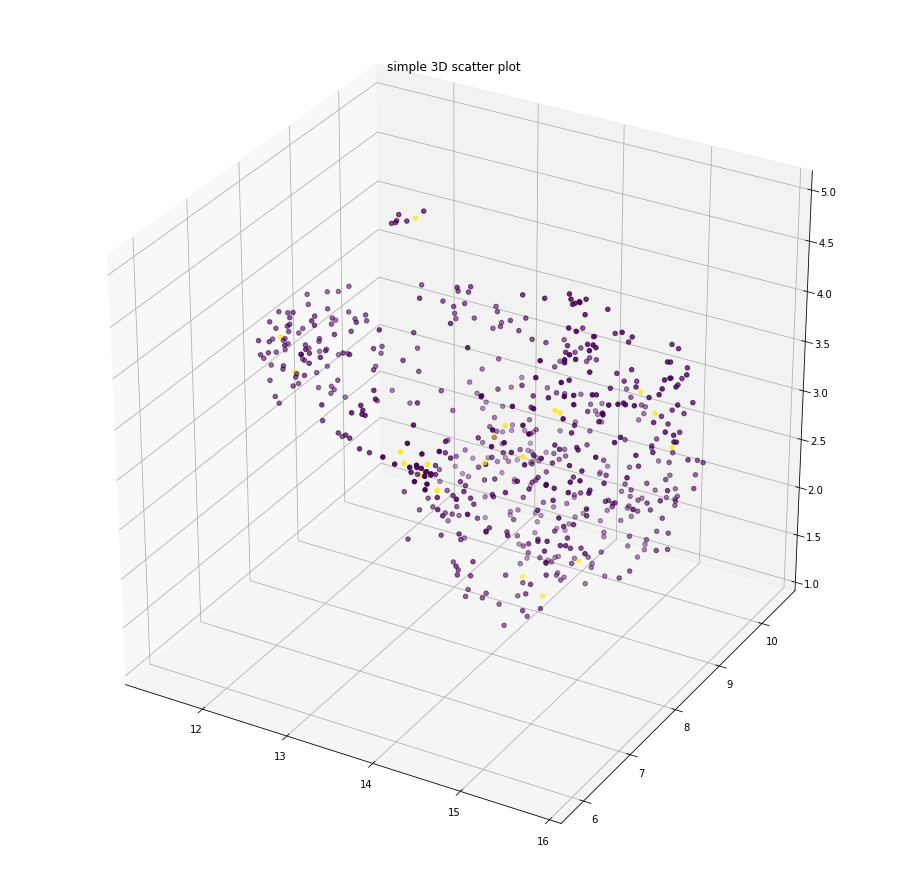

In [ ]:
UMAP_plot_3D(emb_distilled,text_search)

# Useful Code Snippets

counting documents including a concept

In [ ]:
distilled_counter, original_counter = 0,0
trg = 'beer'
for item in distilled_docs:
  if ' '.join(item).find(trg) != -1:
    distilled_counter +=1 
for item in texts:
  if item.find(trg) != -1:
    original_counter +=1 

In [ ]:
print(f"original docs  - {original_counter} --- distilled docs - {distilled_counter}")

original docs  - 3032 --- distilled docs - 1175


SetFit Model - Neural Compression

In [ ]:
!pip install setfit neural_compressor optimum[onnxruntime]==1.5.0 onnxruntime_extensions

In [ ]:
from transformers import pipeline
%%capture
model = SentenceTransformer('all-MiniLM-L6-v2')

Utilities

The below is the data prep for th multiclass classification

In [ ]:
#Multiple values can be selected with shift and/or ctrl (or command) pressed and mouse clicks or arrow keys.
picker = widgets.SelectMultiple(
    options=top_10,
    #value=['Oranges'],
    #rows=10,
    description='Concepts',
    disabled=False
)
display(picker)

SelectMultiple(description='Concepts', options=('white head', 'head', 'pours', 'hops', 'Nice', 'light', 'malt'…

In [ ]:
input = list(picker.value)

In [ ]:
def groups(concepts, docs):
  targets = {}
  for item in concepts:
    targets[item] = []
  for key in targets:
    for ind, item in enumerate(docs):
      if key in item:
        targets[key].append((ind,item))
    if len(targets[key]) < 20 and len(targets[key]) > 10:
      print(f"this class has only: {len(targets[key])} examples, are you sure you want to train the model for this?")  
    if len(targets[key]) < 10:
      print(f"this class has only: {len(targets[key])} examples, proceed at you own risk, it probably won't end up well...?") 
    print(f'there are {len(targets[key])} examples in the selected class') 
  return targets

In [ ]:
out = groups(input, distilled_docs)

there are 66 examples in the selected class
there are 10 examples in the selected class
this class has only: 8 examples, proceed at you own risk, it probably won't end up well...?
there are 8 examples in the selected class


PPrint Ulitily

In [ ]:
import pprint
pp = pprint.PrettyPrinter(width = 80)

In [ ]:
pp.pprint(texts[:4])

['A lot of foam. But a lot. In the smell some banana, and then lactic and '
 'tart. Not a good start. Quite dark orange in color, with a lively '
 'carbonation (now visible, under the foam). Again tending to lactic sourness. '
 'Same for the taste. With some yeast and banana.',
 'Dark red color, light beige foam, average. In the smell malt and caramel, '
 'not really light. Again malt and caramel in the taste, not bad in the end. '
 'Maybe a note of honey in teh back, and a light fruitiness. Average body. In '
 'the aftertaste a light bitterness, with the malt and red fruit. Nothing '
 'exceptional, but not bad, drinkable beer.',
 'Almost totally black. Beige foam, quite compact, not bad. Light smell, just '
 'a bit of roast, and some hop. A bit too light. The taste is light oo, and '
 'drinkable, with some malt, roast, hints of coffee. Nothing exceptional, but '
 'after all drinkable and pleasant. Light to average body. In the aftertaste '
 'some dust, somr roast, hint of caramel, and

Visualization

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# visualization code - PCA
from sklearn.decomposition import PCA
def PCA_plot(emb):
  pca = PCA(n_components=2)
  #Creates and PCA model and plots it
  principal_comp = pca.fit_transform(emb)

  x = []
  y = []
  for value in principal_comp:
    x.append(value[0])
    y.append(value[1])
        
  plt.figure(figsize=(16, 16)) 
  #Outputting all the embeddings
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
  plt.show()

In [ ]:
# visualization code - PCA - 3D
from sklearn.decomposition import PCA
def PCA_plot_3D(emb):
  pca = PCA(n_components=3)
  #Creates and PCA model and plots it
  principal_comp = pca.fit_transform(emb)

  x = []
  y = []
  z = []
  for value in principal_comp:
    x.append(value[0])
    y.append(value[1])
    z.append(value[2])
        
  plt.figure(figsize=(16, 16)) 
  # Creating figure
  fig = plt.figure(figsize = (16, 16))
  ax = plt.axes(projection ="3d")
  
  # Creating plot
  ax.scatter3D(x, y, z, color = "blue")
  plt.title("simple 3D scatter plot")

  #Outputting all the embeddings
  #for i in range(len(x)):
    #plt.scatter(x[i],y[i])
  plt.show()

<Figure size 1152x1152 with 0 Axes>

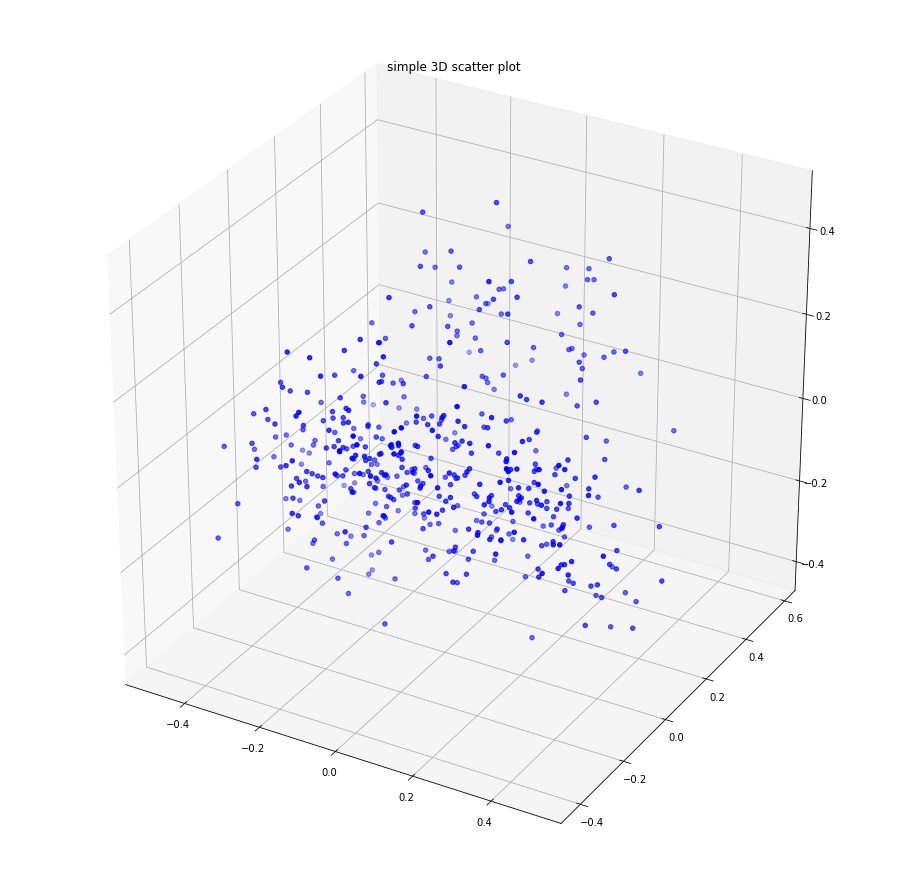

In [ ]:
PCA_plot_3D(emb_distilled)

SetFit test code using Hugginface Datasets

In [ ]:
# Load a dataset from the Hugging Face Hub
dataset = load_dataset("sst2")

# Simulate the few-shot regime by sampling 8 examples per class
num_classes = 2
train_dataset = dataset["train"].shuffle(seed=42).select(range(8 * num_classes))
eval_dataset = dataset["validation"]

In [ ]:
# Load a SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"sentence": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

In [ ]:
# Train and evaluate
trainer.train()
metrics = trainer.evaluate()

In [ ]:
metrics

{'accuracy': 0.6559633027522935}

TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
dataset = [
    "I enjoy reading about Machine Learning and Machine Learning is my PhD subject",
    "I would enjoy a walk in the park",
    "I was reading in the library"
]

In [ ]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(dataset)
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))

spaCY

In [ ]:
import spacy 
from spacy.language import Language 

In [ ]:
# text processing      
nlp = spacy.load('en_core_web_sm')        
#df['Tokens'] = df.Sumcription.apply(lambda x: nlp(x))    
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS        
#spacy_stopwords.add('attach')
#df['Lema_Token']  = df.Tokens.apply(lambda x: " ".join([token.lemma_ for token in x if token not in spacy_stopwords]))

In [ ]:
@Language.component("info_component")
def my_component(doc):
    #print(f"After tokenization, this doc has {len(doc)} tokens.")
    print("The lemmatized tokens are:", [token.lemma_ for token in doc])
    return doc

nlp = spacy.load("en_core_web_sm", disable = ['ner'])
pipeline = ["tok2vec", "parser", "lemmatizer"]

nlp.add_pipe("info_component", name="print_info",last=True)
print(nlp.pipe_names)  # ['tagger', 'parser', 'ner', 'print_info']
doc = nlp("This is a sentence.")

In [ ]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
tokens = [token.lemma_ for token in doc if token.lemma_ not in spacy_stopwords and not token.is_punct]  

In [ ]:
#tensors
vectors = [item.tensor for item in doc]
# not lemmatized tokens
tokens = [item.text for item in doc]

In [ ]:
# NLP Pipelien
nlp = spacy.load("en_core_web_sm")
doc = nlp("This is a sentence.")
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [ ]:
for doc in nlp.pipe(texts[:20]):
  print(doc.ents)

In [ ]:
texts_spacy = []
for doc in nlp.pipe(texts[:3000]):
  tokens = [token.lemma_ for token in doc if token.lemma_ not in spacy_stopwords and not token.is_punct]

  texts_spacy.append(' '.join(tokens))

In [ ]:
texts_spacy_texts = []
for doc in nlp.pipe(texts[:3000]):
  tokens = [token.text for token in doc if token.text not in spacy_stopwords and not token.is_punct]
  texts_spacy_texts.append(' '.join(tokens))

In [ ]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(texts[:3000])
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(50))

Rake-NLTK

In [ ]:
%%capture
!pip install rake_nltk

In [ ]:
from rake_nltk import Rake
import nltk
%%capture
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
rake_nltk_var = Rake(include_repeated_phrases=False, min_length=1, max_length=3)
rake_nltk_var.extract_keywords_from_text(long_text)
keyword_extracted = rake_nltk_var.get_ranked_phrases_with_scores()
#print(keyword_extracted)

Higging Face SetFit training block (alternative to the above)

In [ ]:
# Load a SetFit model from Hub
model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2",
    use_differentiable_head=True,
    head_params={"out_features": num_classes},
)

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"sentence": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

# Train and evaluate
trainer.freeze() # Freeze the head
trainer.train() # Train only the body

# Unfreeze the head and freeze the body -> head-only training
trainer.unfreeze(keep_body_frozen=True)
# or
# Unfreeze the head and unfreeze the body -> end-to-end training
trainer.unfreeze(keep_body_frozen=False)

trainer.train(
    num_epochs=25, # The number of epochs to train the head or the whole model (body and head)
    batch_size=16,
    body_learning_rate=1e-5, # The body's learning rate
    learning_rate=1e-2, # The head's learning rate
    l2_weight=0.0, # Weight decay on **both** the body and head. If `None`, will use 0.01.
)
metrics = trainer.evaluate()

# Push model to the Hub
trainer.push_to_hub("my-awesome-setfit-model")

# Download from Hub and run inference
model = SetFitModel.from_pretrained("lewtun/my-awesome-setfit-model")
# Run inference
preds = model(["i loved the spiderman movie!", "pineapple on pizza is the worst 🤮"]) 

SBERT Testing Code

In [ ]:
#Embedding Demo code (how to calculate distances btw vectors)
#Compute embedding 
embeddings1 = model.encode([texts[0]], convert_to_tensor=True)
embeddings2 = model.encode([' '.join(distilled_docs[0])], convert_to_tensor=True)

#Compute cosine-similarities
cosine_score = util.cos_sim(embeddings1, embeddings2)

In [ ]:
embeddings1 = model.encode([texts[5]], convert_to_tensor=True)
cosine_score = util.cos_sim(embeddings1, embeddings2)

Setfit creating training dataset for multilable classfier

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ethos", "multilabel")

In [ ]:
dataset['train'][382]

In [ ]:
import numpy as np

features = dataset["train"].column_names
features.remove("text")
#features

num_samples = 2
samples = np.concatenate(
    [np.random.choice(np.where(dataset["train"][f])[0], num_samples) for f in features]
)

def encode_labels(record):
    return {"labels": [record[feature] for feature in features]}
dataset = dataset.map(encode_labels)

train_dataset = dataset["train"].select(samples)

KeyBert

In [ ]:
%%capture
!pip install keybert

In [ ]:
from keybert import KeyBERT
kw_model = KeyBERT()

In [ ]:
keywords = kw_model.extract_keywords(corpus, keyphrase_ngram_range=(1, 3), top_n=50, stop_words=None)
keywords

[('tasting pale ale', 0.6007),
 ('ale fruitiness', 0.5896),
 ('yeastiness flavor nice', 0.5848),
 ('yeastiness flavor', 0.5824),
 ('like yeastiness flavor', 0.5817),
 ('pale ale aroma', 0.5811),
 ('pale ale taste', 0.5769),
 ('of ale fruitiness', 0.5728),
 ('roasted malt aromas', 0.5674),
 ('aftertaste this beer', 0.5672),
 ('light beer aftertaste', 0.5657),
 ('tasty pale ale', 0.5647),
 ('typical pale ale', 0.56),
 ('pale ale smell', 0.5581),
 ('caramel malt aroma', 0.5579),
 ('good pale ale', 0.5543),
 ('beer aftertaste', 0.5536),
 ('beer aftertaste this', 0.5518),
 ('dark brown ale', 0.5466),
 ('after taste weird', 0.5459),
 ('decent pale ale', 0.5441),
 ('yeasty fruitiness greeted', 0.5433),
 ('creaminess and roast', 0.5433),
 ('tasty brew appearance', 0.5425),
 ('some pale ale', 0.5424),
 ('ale with foamy', 0.5411),
 ('yeasty fruitiness', 0.5405),
 ('pale ale appears', 0.5403),
 ('roasty brown ale', 0.54),
 ('brown ale good', 0.5399),
 ('taste very light', 0.5399),
 ('astringent t

In [ ]:
# changing cell value based on the condition
import pandas as pd
import numpy as np
  
# data
Student = {
    'Name': ['John', 'Jay', 'sachin', 'Geetha', 'Amutha', 'ganesh'],
    'gender': ['male', 'male', 'male', 'female', 'female', 'male'],
    'math score': [50, 100, 70, 80, 75, 40],
    'test preparation': ['none', 'completed', 'none', 'completed',
                         'completed', 'none'],
}
  
# creating a Dataframe object
df = pd.DataFrame(Student)
  
# Applying the condition
df.loc[df["gender"] == "male", "gender"] = 1
# change column type to str
df['Age'] = df['Age'].apply(str)
# select rows by type:
df[df['A'].apply(lambda x: isinstance(x, str))]